<a href="https://colab.research.google.com/github/mandudu/Machine-Learning-Projects/blob/main/Naive_Bayes_vs_Logistic_Regression_James_Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes vs Logistic Regression (40 Points)

In this notebook we shall explore the difference between a generative model, Naive Bayes, and a discriminative model, Logistic Regression. *Avoid loops throughtout* (i.e. write efficient code).

## Data and Setup

First, it may help to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, confirm that we can connect to the GPU with tensorflow.

*(Note, it is fine if you can not connect to GPU, it just might take a little longer to run.)*

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


Let's import additional packages of use.

In [ ]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

**Reading data**

Let's use some helper functions to read in pregenerated 2d data for classification. `X` and `Y` will be `N x 2` input features and `N x 1` binary output labels, respectively.

In [ ]:
def read_dataset(url):
  data = pd.read_csv(url).to_numpy()
  X = data[:, :-1]
  Y = data[:, -1, None]
  return X.astype(np.float32), Y.astype(np.float32)

In [ ]:
url1 = 'https://raw.githubusercontent.com/lupalab/comp755_f21/main/hw3_1.csv'
X, Y = read_dataset(url1)

## Naive Bayes
First we shall estimate a *generative* model using Naive Bayes and Gaussians.

**Estimating Naive Bayes Parameters (5 Points)**

As in the write up, we will use a Naive Bayes assumption with Gaussian distributions (with unit variance and unknown means). Estimate the parameters of this Naive Bayes Model below.

In [ ]:
def estimate_naive_bayes(X, Y):
  """
  Estimates the paramters of the Gaussian Naive Bayes model.
  Args:
    X: Nxd matrix of input features
    Y: Nx1 vector of output labels
  Returns:
    pi1: real, class prior probability for class 1
    mu1: 1 x d vector, parameters for class 1
    mu0: 1 x d vector, parameters for class 0
  """
  #mu1 equals to the mean of x input features that contains an output of 1
  #mu0 equals to the mean of x input features that contains an output of 0
  #pi1 equals to len(Y = 1)/N
  #pi1, mu1, mu0 = None, None, None  # TODO
  dfx = pd.DataFrame(X)
  dfy = pd.DataFrame(Y, columns=['Y'])
  pi1 = np.count_nonzero(dfy)/dfy.shape[0]

  dfxy = pd.concat([dfx,dfy],axis=1)
  mu1 = dfxy.loc[dfxy['Y']==1].mean().to_numpy()
  mu1 = np.delete(mu1, -1)
  mu0 = dfxy.loc[dfxy['Y']==0].mean().to_numpy()
  mu0 = np.delete(mu0, -1)

  return pi1, mu1, mu0

In [ ]:
pi1, mu1, mu0 = estimate_naive_bayes(X, Y)

**Generating with the Generative Model (3 Points)**

We saw in class that Naive Bayes is a generative approach. We will use this model to now generatie synthetic data.

In [ ]:
def generate_naive_bayes(N, pi1, mu1, mu0):
  """
  Generate synthetic samples according to Naive Bayes model
  Args:
    N: int, number of samples to generate
    pi1: real, class prior probability for class 1
    mu1: 1 x d vector, parameters for class 1
    mu0: 1 x d vector, parameters for class 0
  Returns:
    X: Nxd matrix, synthetic input feature samples
    Y: Nx1 vector, synthetic output label samples
  """
  # X, Y = None, None  # TODO
  no_Y = int(pi1*N)
  Y_1 =np.array([np.ones(no_Y)]).T
  Y_0 =np.array([np.zeros(int(N-Y_1.shape[0]))]).T
  Y = np.concatenate((Y_1,Y_0))
  X_0 = np.random.multivariate_normal(mu0, np.eye(2), 200-Y_1.shape[0])
  X_1 = np.random.multivariate_normal(mu1, np.eye(2), Y_1.shape[0])
  X =  np.concatenate((X_1,X_0))
  return X, Y

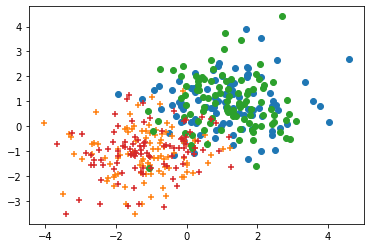

In [ ]:
tXhat, Yhat = generate_naive_bayes(200, pi1, mu1, mu0)
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')
plt.scatter(Xhat[np.equal(Yhat[:,-1], 0), 0], Xhat[np.equal(Yhat[:,-1], 0), 1])
plt.scatter(Xhat[np.equal(Yhat[:,-1], 1), 0], Xhat[np.equal(Yhat[:,-1], 1), 1], marker='+')

Should look pretty good! (I.e. the generated data should match up with the training data.)

**Predicting with the Generative Model (2 Points)**

In addition to generating synthetic data, we can also use the generative model to make predictions. We implement this below.

In [ ]:
def naive_bayes_pred(x, pi1, mu1, mu0):
  """
  Make predictions using Naive Bayes model.
  Args:
    x: mxd matrix of input feature vectors for m queries
    pi1: real, class prior probability for class 1
    mu1: 1 x d vector, parameters for class 1
    mu0: 1 x d vector, parameters for class 0
  Returns:
    Yhat: mx1 vector of floats in {0.0, 1.0}, predicted output label samples
  """
  p0 = pdf(mu0,1, x, (1-pi1))
  p1 = pdf(mu1,1, x, pi1)
  Yhat = np.reshape(np.array([0 if i<0 else 1 for i in (p1-p0)]),(-1,1))
  return Yhat

def pdf(mean, var,x, prior):
  numerator = np.exp(-(x-mean)**2/(2*var)).prod(axis=1)*prior
  denominator = np.sqrt(2*np.pi*var)
  return numerator/denominator

**Plot Decision Boundary (1 Point)**

Next we'll use this helper function to plot our decision surface.

In [ ]:
def plot_grid(pred_func):
  # Reduce the number of grid points if there is a memory issue
  gridx = np.float32(np.linspace(-6.0, 6.0, 100))
  gridx1, gridx2 = np.meshgrid(gridx, gridx)
  g1 = np.reshape(gridx1, [-1, 1])
  g2 = np.reshape(gridx2, [-1, 1])
  func_vals = pred_func(np.concatenate((g1, g2), -1))
  plt.contourf(gridx1, gridx2, np.reshape(func_vals, gridx1.shape), 64)
  plt.xlabel('x1')
  plt.ylabel('x2')
  cbar = plt.colorbar()
  cbar.solids.set_edgecolor('face')
  plt.draw()
  return func_vals, g1, g2

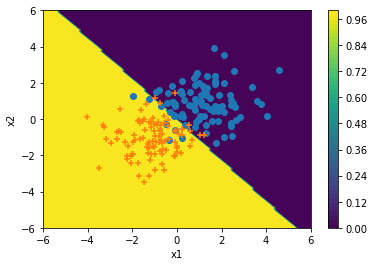

In [ ]:
plot_grid(lambda x: naive_bayes_pred(x, pi1, mu1, mu0))  # TODO (hint, use naive_bayes_pred)
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')

**Computing Accuracy (2 Points)**

Lastly, we shall compute the accuracy of predictions with a helper function.

In [ ]:
def accuracy(X, Y, pred_func):
  """
  Helper function that returns the accuracy of a prediction function 
  for given data.
  Args:
    X: Nxd matrix of input features
    Y: Nx1 vector of true output labels
    pred_func: function that takes in X and outputs Nx1 vector of predictions
  Returns:
    accu: float, accuracy of pred_func on (X, Y)
  """
  accu = np.sum(np.equal(Y, 1) == pred_func(X))/pred_func(X).shape[0]
  return accu

In [ ]:
accu = accuracy(X, Y, lambda x:naive_bayes_pred(x,pi1,mu1,mu0))  # TODO: get accuracy for naive bayes
# lambda functions are often useful!
print('Naive Bayes Accuracy on Training Data: {}'.format(accu))

Naive Bayes Accuracy on Training Data: 0.9296482412060302


## Logistic Regression
We now move on to training a *discriminative* model, logistic regression.

**Predictions with Logistic Regression (2 Points)**

First we shall implement how to make predictions using input features `x` and parameters `beta`.

x.shape

In [ ]:
import cv2
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.pyplot as plt
# from functions import load_image
def load_image(name):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.resize(img, (64, 48), interpolation = cv2.INTER_AREA)
    return img
def get_distance_transform(img_rgb):
    """
    Get distance to the closest background pixel for an RGB image
    Input:
        img_rgb: np.array , HxWx3 RGB image
    Output:
        dist: np.array , HxWx1 distance image
        each pixel’s intensity is proportional
        to its distance to the closest background
        pixel scaled to [0..255] for plotting
    """
    # Threshold the image: any value above 0 maps into 255
    thresh = cv2.threshold(img_rgb , 0, 255, cv2.THRESH_BINARY)[1]
    # Collapse the color dimension
    thresh = thresh.any(axis=2)
    # Pad to make sure the border is treated as background np.pad(thresh , 1)
    thresh = np.pad(thresh, 1)
    # Get distance transform
    dist = distance_transform_edt(thresh)[1:-1, 1:-1]
    # HxW -> HxWx1
    dist = dist[:, :, None]
    return dist / dist.max() * 255.0
# Feature detection and description
img1_rgb = cv2.imread("/content/yosemite1.jpg")
img2_rgb = cv2.imread("/content/yosemite2.jpg")
img1 = cv2.cvtColor(img1_rgb, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
key_point1, descriptor1 = sift.detectAndCompute(img1,None)
key_point2, descriptor2 = sift.detectAndCompute(img2,None)
img1_result=cv2.drawKeypoints(img1_rgb,key_point1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('keypoints.png', img1_result)
# Feature matching and image alignment
matcher = cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)
matches = matcher.match(descriptor1,descriptor2)
matches = sorted(matches, key = lambda x:x.distance)
res = cv2.drawMatches(img1_rgb,key_point1,img2_rgb,key_point2,matches[:10],None,flags=2)
cv2.imwrite("top10_matching.png",res)
pts1 = np.array([key_point1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
pts2 = np.array([key_point2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
M, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)      #img2 to img1 Matrix
result = cv2.warpPerspective(img2_rgb, M, (img1_rgb.shape[1] + img2_rgb.shape[1], img1_rgb.shape[0]))
result = result/2
result[0:img1_rgb.shape[0], 0:img1_rgb.shape[1]] += img1_rgb/2
cv2.imwrite("warp1.png",result)
result = cv2.warpPerspective(img2_rgb, M, (img1_rgb.shape[1] + img2_rgb.shape[1], img1_rgb.shape[0]))
result[0:img1_rgb.shape[0], 0:img1_rgb.shape[1]] = img1_rgb
cv2.imwrite("warp2.png",result)

result2 = cv2.warpPerspective(img2_rgb, M, (img1_rgb.shape[1] + img2_rgb.shape[1], img1_rgb.shape[0]))
result2 = result2
result1 = np.zeros(result2.shape)
result1[0:img1_rgb.shape[0], 0:img1_rgb.shape[1]] = img1_rgb
distance1 = get_distance_transform(result1)
distance2 = get_distance_transform(result2)

w1 = distance1 / np.maximum((distance1+distance2),1)
w2 = distance2 / np.maximum((distance1+distance2),1)
result = result1*w1 + result2*w2
result = result.astype("uint8")
cv2.imwrite("weight1.png",w1*255)
cv2.imwrite("weight2.png",w2*255)
cv2.imwrite("weight1+2.png",(w1+w2)*255)
cv2.imwrite("warp3.png",result)

**Log Likelihood (8 Points)**

Next we shall compute the mean loglikelihood according to the logistic model: $\frac{1}{N} \sum_{i=1}^N \log\,p_{\beta}(Y_i \mid X_i)$.

In [ ]:
def mean_logistic_loglikelihood(X, Y, beta):
  """
  Returns mean loglikelihood.
  Args:
    X: Nxd matrix of input features
    Y: Nx1 vector of true output labels
    beta: (d+1)x1 vector of model parameters where beta[-1, 0] is intercept term
  Returns:
    mll: scalar of mean loglikelihood according to beta for data points
  """
  # No loops allowed!
  # You must use tf.nn.softplus!
  # Do not used any library implementations of cross entropy!
  X = tf.concat((X, np.ones((X.shape[0],1))),1)
  log = Y*(-tf.nn.softplus(tf.matmul(-X,beta)))+(1-Y)*(-tf.nn.softplus(tf.matmul(X,beta)))
  mll = tf.math.reduce_sum(log)/X.shape[0]
  return mll

**Compute Logistic Regression Gradient (3 Points)**

Next, we shall implement the gradient to the `mean_logistic_loglikelihood` as a function of `beta`. We'll compare to using Tensorflow to compute this gradient automagically; but first, let's roll up our sleeves! (*Note: the gradient is derived in the slides, no need to rederive!*)

In [ ]:
def mean_logistic_loglikelihood_gradient(X, Y, beta):
  """
  Returns the gradient of mean loglikelihood loss 
  (i.e. negative mean likelihood) w.r.t. beta.
  Args:
    X: Nxd matrix of input features
    Y: Nx1 vector of true output labels
    beta: (d+1)x1 vector of current model parameters 
      where beta[-1, 0] is intercept term
  Returns:
    beta_grad: (d+1)x1 vector of gradients (partial derivates) evaluated at beta
  """
  # No loops allowed!
  n = X.shape[0]
  X = tf.concat((X,tf.ones((n,1))),1)
  grad = Y-1/(1+np.exp(tf.matmul(-X, beta)))
  beta_grad = -tf.math.reduce_sum(grad*X, axis=0)
  beta_grad = tf.reshape(beta_grad/n,[-1,1])  
  return beta_grad

Check your implementation, it should be *very* close to the same answer that Tensorflow's autodiff provides.

In [ ]:
def mean_logistic_loglikelihood_tfgrad(X, Y, beta):
  with tf.GradientTape() as tape:
    loss_value = -mean_logistic_loglikelihood(X, Y, beta)
  g = tape.gradient(loss_value, [beta])[0]
  return tf.cast(g, tf.float32)

beta_init = (np.random.randn(3, 1)*0.1).astype(np.float32)
beta_grad = mean_logistic_loglikelihood_gradient(X, Y, beta_init)

beta_var = tf.Variable(shape=(3,1), initial_value=beta_init)
beta_tfgrad = mean_logistic_loglikelihood_tfgrad(X, Y, beta_var)

print('Own implementation:\n{}\nautograd:\n{}\nnorm: {}'.format(
    beta_grad.numpy(), beta_tfgrad.numpy(), 
    tf.norm(beta_grad-beta_tfgrad, axis=0)))

Own implementation:
[[ 0.5118369 ]
 [ 0.48570287]
 [-0.04637875]]
autograd:
[[ 0.5118369 ]
 [ 0.4857028 ]
 [-0.04637875]]
norm: [6.00685e-08]


We'll train the logistic regression model with gradient descent. You will have the `gradient_descent` function implemented, but you'll have to figure out the right arguement/parameters to feed into it to train an effective model.

In [ ]:
def gradient_descent(beta_init, lossfunc, gradfunc, 
                     t=5e-5, lr_decay=1e-2, nsteps=100):
  """
  Run gradient descent for n steps starting from beta_init with t step size, 
  which is decayed lr_decay much each iteration.
  Args:
    beta_init: (d+1)x1 vector of initial model parameters to begin 
      gradient descent from
    lossfunc: (d+1)x1 -> scalar function that we are minimizing
    gradfunc: (d+1)x1 -> (d+1)x1 function that computes gradients at current 
      parameter
    t: float, step size for updates
    lr_decay: float, amount to decay t by after each step `t *= (1-lr_decay)`
    nsteps: int, number of updates to make
  Returns:
    beta_var: (d+1)x1 vector variable with optimized values
  """
  beta_var = tf.Variable(shape=beta_init.shape, initial_value=beta_init)

  for i in range(0, nsteps):
    beta_var.assign(beta_var - t*gradfunc(beta_var))
    t *= (1-lr_decay)
    plt.scatter(i, lossfunc(beta_var), marker='.')

  return beta_var

**Train your model (3 Points)**

Use the `gradient_descent`function to optimize a good logistic regression classifier. Note: *you will have to play with some of the parameters of gradient descent*.

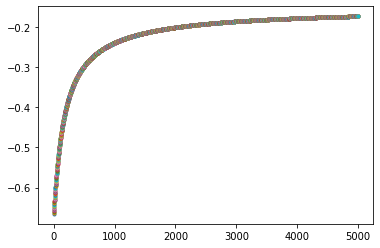

In [ ]:
beta_opt = gradient_descent((np.random.randn(3,1)*0.1).astype(np.float32), 
                            lambda beta: mean_logistic_loglikelihood(X,Y,beta),
                            lambda beta: mean_logistic_loglikelihood_gradient(X,Y,beta), 
                            t = 5e-3, lr_decay = 1e-5, nsteps = 5000)



**Plot Decision Boundary (1 Point)**

Plot the decision surface for the learned logistic regression model

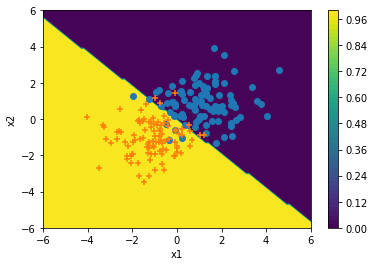

In [ ]:
plot_grid(lambda x:logistic_pred(x,beta_opt))  # TODO (hint, use logistic_pred)
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')

**Compute accuracy (1 Points)**

Compute the accuracy of the learned logistic regression model. (Hint: you should see over 94% accuracy on training data.)

In [ ]:
accu = accuracy(X, Y, lambda x: logistic_pred(x, beta_opt))  # TODO: remove
print('Logistic Regression Accuracy on Training Data: {}'.format(accu))

Logistic Regression Accuracy on Training Data: 0.9447236180904522


## A Tricky Case

Above we saw that both Naive Bayes and logistic regression performed well. Next, we will look at a case where this is no longer true and we will assess what went wrong.

In [ ]:
url2 = 'https://raw.githubusercontent.com/lupalab/comp755_f21/main/hw3_2.csv'
X, Y = read_dataset(url2)

### Naive Bayes

First, let's see how Naive Bayes performs on the new dataset. We'll estimate parameters, and draw samples.

In [ ]:
pi1, mu1, mu0 = estimate_naive_bayes(X, Y)

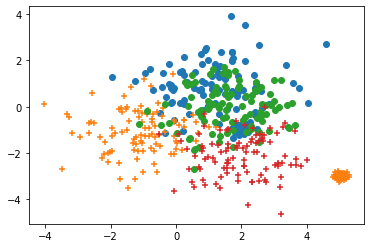

In [ ]:
Xhat, Yhat = generate_naive_bayes(200, pi1, mu1, mu0)
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')
plt.scatter(Xhat[np.equal(Yhat[:,-1], 0), 0], Xhat[np.equal(Yhat[:,-1], 0), 1])
plt.scatter(Xhat[np.equal(Yhat[:,-1], 1), 0], Xhat[np.equal(Yhat[:,-1], 1), 1], marker='+')

**Decision Surface and Accuracy (2 Points)**

Let's now plot the decision surface and compute the training accuracy as before.

Naive Bayes Accuracy on Training Data: 0.6741854636591479


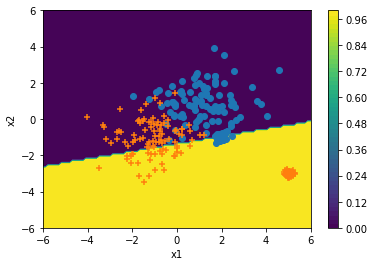

In [ ]:
plot_grid(lambda x: naive_bayes_pred(x, pi1, mu1, mu0))  # TODO
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')

accu = accuracy(X,Y, lambda x: naive_bayes_pred(x, pi1, mu1, mu0))  # TODO
print('Naive Bayes Accuracy on Training Data: {}'.format(accu))

Notice any differences from last time?

### Logistic Regression

**Train and Assess (2 Points)**

We shall now optimize logistic regresion for the new data, plot the decision surface, and get the training data accuracy (as before).

Logistic Regression Accuracy on Training Data: 0.9573934837092731


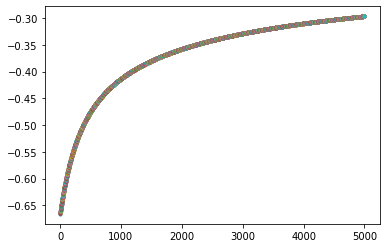

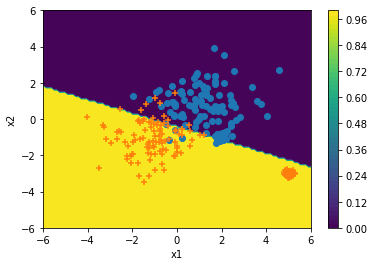

In [ ]:
beta_opt = gradient_descent((np.random.randn(3, 1)*0.1).astype(np.float32), 
                            lambda beta: mean_logistic_loglikelihood(X,Y,beta),
                            lambda beta: mean_logistic_loglikelihood_gradient(X,Y,beta), 
                            t = 5e-3, lr_decay = 1e-5, nsteps = 5000)

plt.figure()
plot_grid(lambda x: logistic_pred(x, beta_opt))  # TODO (hint, use logistic_pred)
plt.scatter(X[np.equal(Y[:,-1], 0), 0], X[np.equal(Y[:,-1], 0), 1])
plt.scatter(X[np.equal(Y[:,-1], 1), 0], X[np.equal(Y[:,-1], 1), 1], marker='+')

accu = accuracy(X, 
                Y, 
                lambda x: logistic_pred(x, beta_opt))  # TODO
print('Logistic Regression Accuracy on Training Data: {}'.format(accu))

Notice any differences from last time?

### Big Picture

**What went wrong? What is different? (5 Points)**

It's no longer the case that both models work well, why is that? Why do/don't things break?

*TODO: Respond*
Logistic regression in the above sample works well because of linear separation. Linear separation allows the logistic regression to classify into two classes, which is what is happening in the above examples. 

However, the main goal of Naive bayes is to estimate class prior probability and its mean and variance value. Based on these estimations, we should be able to solve the classification. However, if one of the classes are apart from the other, the classification would be unsolvable like the problem we face above. 